In [73]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [74]:
def pam(data, num_clusters):
    # data: tất cả các điểm dữ liệu, num_cluster: số lượng cụm cần tìm
    num_points = len(data)  # Số điểm dữ liệu

    # Lấy ngẫu nhiên các medoids(điểm trung tâm) từ data và gán chỉ số của medoid đó vào mảng trả về
    medoids_coordinates_index = np.random.choice(num_points, num_clusters, replace=False)  
    
    data_cluster_ids = np.zeros(num_points)  # Tạo mảng chứa id của cluster mà mỗi điểm thuộc về

    for i in range(100):  # Vòng lặp tối đa 100 lần để tối ưu các medoids
        distances = pairwise_distances(data, data[medoids_coordinates_index])  # Tính khoảng cách giữa các điểm và medoids hiện tại
        data_cluster_ids = np.argmin(distances, axis=1)  # Gán mỗi điểm dữ liệu vào cụm tương ứng với medoid gần nhất

        # Tìm các medoid mới cho mỗi cụm
        new_medoids_coordinates_index = []

        # Duyệt qua từng cụm
        for cluster in range(num_clusters):
            # Lấy ra khoảng cách của tất cả các điểm trong cụm hiện tại
            cluster_distances = distances[data_cluster_ids == cluster]
            
            # Tính tổng khoảng cách từ mỗi điểm trong cụm đến các điểm khác trong cụm
            total_distances = np.sum(cluster_distances, axis=0)
            
            # Tìm toạ độ của điểm có tổng khoảng cách nhỏ nhất trong cụm đó
            closest_coordinate = np.argmin(total_distances)
            
            # Thêm toạ độ này vào danh sách các medoid mới
            new_medoids_coordinates_index.append(closest_coordinate)
        
        # Chuyển danh sách thành mảng NumPy và ánh xạ lại thành chỉ số của dữ liệu gốc
        new_medoids_coordinates_index = np.array(medoids_coordinates_index)[new_medoids_coordinates_index]

        if np.all(medoids_coordinates_index == new_medoids_coordinates_index):  # Kiểm tra nếu các medoid không thay đổi thì dừng
            break
        medoids_coordinates_index = new_medoids_coordinates_index  # Cập nhật medoids cho lần lặp tiếp theo
    
    return medoids_coordinates_index, data_cluster_ids

In [75]:
def clara(data, num_clusters, num_samples=5, sample_size=None):
    if sample_size is None:
        sample_size = min(40 + 2 * num_clusters, len(data))  # Xác định kích thước mẫu cho từng lần lặp

    best_medoids_indexes = None  # Lưu trữ các medoid tốt nhất tìm được
    lowest_cost = float('inf')  # Giá trị chi phí thấp nhất tìm được
    best_cluster_assignments = None  # Lưu trữ kết quả phân cụm tốt nhất

    for _ in range(num_samples):  # Thực hiện lặp lại cho num_samples lần
        sample_indexes = np.random.choice(len(data), sample_size, replace=False)  # Chọn ngẫu nhiên một mẫu
        sample_data = data[sample_indexes]  # Tạo tập mẫu từ các chỉ số đã chọn

        medoids_indexes, sample_cluster_assignments = pam(sample_data, num_clusters)  # Chạy thuật toán PAM trên tập mẫu
        global_medoids_indexes = sample_indexes[medoids_indexes]  # Ánh xạ medoids từ mẫu vào toàn bộ dữ liệu

        global_distances = pairwise_distances(data, data[global_medoids_indexes])  # Tính khoảng cách cho toàn bộ tập dữ liệu
        global_cluster_assignments = np.argmin(global_distances, axis=1)  # Gán cụm cho toàn bộ tập dữ liệu
        total_cost = np.sum(np.min(global_distances, axis=1))  # Tính chi phí cho cụm

        if total_cost < lowest_cost:  # Cập nhật medoids và clusters tốt nhất nếu chi phí thấp hơn
            best_medoids_indexes = global_medoids_indexes
            lowest_cost = total_cost
            best_cluster_assignments = global_cluster_assignments

    return best_medoids_indexes, best_cluster_assignments

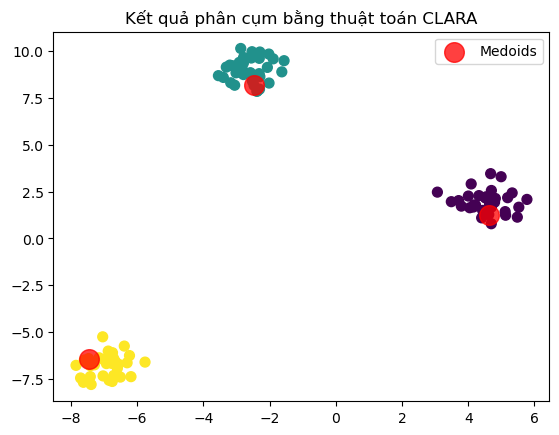

In [76]:
def test_clara_pam():
    data, true_labels = make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=42)  # Tạo dữ liệu giả lập với 3 cụm
    num_clusters = 3  # Số lượng cụm cần tìm
    medoids_indexes, cluster_assignments = clara(data, num_clusters)  # Gọi hàm CLARA để phân cụm dữ liệu
    plt.scatter(data[:, 0], data[:, 1], c=cluster_assignments, s=50, cmap='viridis')  # Vẽ các điểm dữ liệu và cụm
    plt.scatter(data[medoids_indexes, 0], data[medoids_indexes, 1], c='red', s=200, alpha=0.75, label='Medoids')  # Vẽ medoids
    plt.title("Kết quả phân cụm bằng thuật toán CLARA")  # Đặt tiêu đề
    plt.legend()  # Hiển thị chú thích
    plt.show()  # Hiển thị đồ thị

test_clara_pam()